# 虛擬貨幣 CTA 回測框架
* 作者：TMBA 22屆負責人 江祐宏
* 如果有發現寫錯的地方請跟我聯繫！

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

path = os.getcwd()
print(path)

/Users/alex/Documents/TMBA程式交易部/23_1


## 撈資料
* [FTX api document](https://docs.ftx.com/#overview)
* [yfinance](https://pypi.org/project/yfinance/)

In [2]:
# 可能有些人電腦天生問題，無法使用 yfinance

data = yf.Ticker('TSLA')
TSLA = data.history(period='D', start='2018-1-1', end='2022-6-30')
TSLA.to_csv(path+'/TSLA.csv')

In [3]:
TSLA = pd.read_csv(path+'/TSLA.csv', index_col = 0, parse_dates = True)
print(TSLA.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1131 entries, 2018-01-02 to 2022-06-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1131 non-null   float64
 1   High          1131 non-null   float64
 2   Low           1131 non-null   float64
 3   Close         1131 non-null   float64
 4   Volume        1131 non-null   int64  
 5   Dividends     1131 non-null   int64  
 6   Stock Splits  1131 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 70.7 KB
None


In [4]:
TSLA.iloc[0:2]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02,62.400002,64.421997,62.200001,64.106003,21761000,0,0.0
2018-01-03,64.199997,65.050003,63.110001,63.450001,22607500,0,0.0


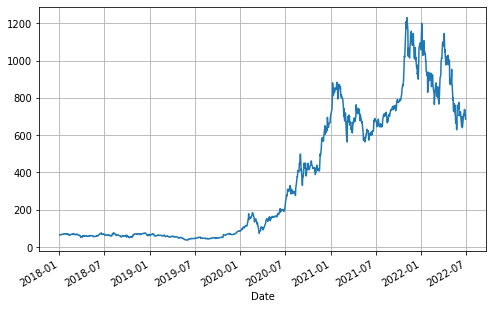

In [5]:
TSLA['Close'].plot(figsize=(8,5), grid=True);

In [6]:
# 預設是 UTC +0

symbol = 'BTC-PERP'
resolution = 60

url = f'https://ftx.com/api/markets/{symbol}/candles?resolution={resolution}&limit=1440'
response = requests.get(url)
if response.status_code == 200:
    result = response.json()['result']

result[0]

{'startTime': '2022-08-04T08:46:00+00:00',
 'time': 1659602760000.0,
 'open': 22856.0,
 'high': 22857.0,
 'low': 22841.0,
 'close': 22843.0,
 'volume': 826314.3285}

In [7]:
btc = pd.DataFrame(result)
print(btc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   startTime  1440 non-null   object 
 1   time       1440 non-null   float64
 2   open       1440 non-null   float64
 3   high       1440 non-null   float64
 4   low        1440 non-null   float64
 5   close      1440 non-null   float64
 6   volume     1440 non-null   float64
dtypes: float64(6), object(1)
memory usage: 78.9+ KB
None


In [8]:
btc.iloc[0:2]

,startTime,time,open,high,low,close,volume
0,2022-08-04T08:46:00+00:00,1.659603e+12,22856.0,22857.0,22841.0,22843.0,8.263143e+05
1,2022-08-04T08:47:00+00:00,1.659603e+12,22843.0,22843.0,22825.0,22836.0,1.623151e+06


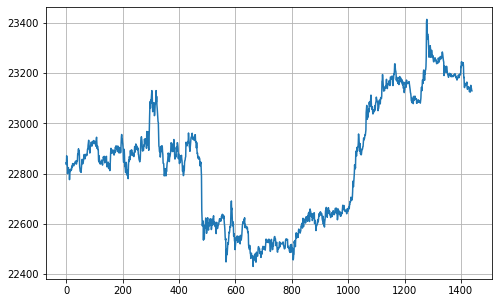

In [9]:
btc['close'].plot(figsize=(8,5), grid=True);

### 錄 BTC 1分K

In [10]:
symbol = 'BTC-PERP'

startTime = '2021-1-1'
endTime = '2022-8-1'
resolution = 60

startTimeStamp = dt.datetime.strptime(startTime, "%Y-%m-%d").timestamp()
endTimeStamp = dt.datetime.strptime(endTime, "%Y-%m-%d").timestamp()
data = []

while True:
    if startTimeStamp < endTimeStamp:
        t1 = startTimeStamp
        t2 = startTimeStamp + resolution*1000

        url = 'https://ftx.com/api/markets/{}/candles?resolution={}&limit=1440&start_time={}&end_time={}'.format(symbol, resolution, t1, t2)
        response = requests.get(url)
        if response.status_code == 200:
            result = response.json()['result'][:-1] #最後一筆會重複
            data += result
        else:
            print('error: {}, {} ~ {}'.format(symbol, t1, t2))

        startTimeStamp += resolution*1000
    else:
        break

data = pd.DataFrame(data)
data.index = pd.to_datetime(data['startTime'])
data = data[['open', 'high', 'low', 'close', 'volume']]
data.to_csv(path + '/{}_PERP.csv'.format(symbol.split('-')[0]))

In [11]:
pd.read_csv(path+'/BTC_PERP.csv')

,startTime,open,high,low,close,volume
0,2020-12-31 16:00:00+00:00,28795.5,28837.0,28778.5,28829.0,3.446501e+06
1,2020-12-31 16:01:00+00:00,28829.0,28838.0,28736.5,28742.5,1.504040e+06
2,2020-12-31 16:02:00+00:00,28745.0,28761.0,28707.5,28713.0,2.565665e+06
3,2020-12-31 16:03:00+00:00,28713.0,28737.5,28700.0,28711.0,7.606752e+05
4,2020-12-31 16:04:00+00:00,28711.0,28750.5,28700.5,28735.0,1.022127e+06
...,...,...,...,...,...,...
830876,2022-07-31 17:55:00+00:00,23728.0,23732.0,23723.0,23729.0,2.657220e+05
830877,2022-07-31 17:56:00+00:00,23729.0,23750.0,23729.0,23743.0,9.526063e+05
830878,2022-07-31 17:57:00+00:00,23743.0,23749.0,23737.0,23747.0,3.033448e+05
830879,2022-07-31 17:58:00+00:00,23747.0,23754.0,23730.0,23730.0,5.137801e+05


In [12]:
pd.read_csv(path+'/BTC_PERP.csv', parse_dates=True, index_col='startTime')

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28795.5,28837.0,28778.5,28829.0,3.446501e+06
2020-12-31 16:01:00+00:00,28829.0,28838.0,28736.5,28742.5,1.504040e+06
2020-12-31 16:02:00+00:00,28745.0,28761.0,28707.5,28713.0,2.565665e+06
2020-12-31 16:03:00+00:00,28713.0,28737.5,28700.0,28711.0,7.606752e+05
2020-12-31 16:04:00+00:00,28711.0,28750.5,28700.5,28735.0,1.022127e+06
...,...,...,...,...,...
2022-07-31 17:55:00+00:00,23728.0,23732.0,23723.0,23729.0,2.657220e+05
2022-07-31 17:56:00+00:00,23729.0,23750.0,23729.0,23743.0,9.526063e+05
2022-07-31 17:57:00+00:00,23743.0,23749.0,23737.0,23747.0,3.033448e+05


In [13]:
symbol = 'BTC-PERP'
startTime = '2021-1-1'
endTime = '2022-8-1'

startTimeStamp = dt.datetime.strptime(startTime, "%Y-%m-%d").timestamp()
endTimeStamp = dt.datetime.strptime(endTime, "%Y-%m-%d").timestamp()
data = []

while True:
    if startTimeStamp < endTimeStamp:
        t1 = startTimeStamp
        t2 = startTimeStamp + 86400

        url = 'https://ftx.com/api/funding_rates?start_time={}&end_time={}&future={}'.format(t1, t2, symbol)
        response = requests.get(url)
        if response.status_code == 200:
            result = response.json()['result'][:-1][::-1] #最後一筆會重複 #順序顛倒
            data += result
        else:
            print('error: {}, {} ~ {}'.format(symbol, t1, t2))

        startTimeStamp += 86400
    else:
        break

data = pd.DataFrame(data)
data.index = pd.to_datetime(data['time'])
data = data[['rate']]
data.to_csv(path + '/{}_funding.csv'.format(symbol.split('-')[0]))

In [14]:
pd.read_csv(path+'/BTC_funding.csv')

,time,rate
0,2020-12-31 17:00:00+00:00,-0.000007
1,2020-12-31 18:00:00+00:00,-0.000016
2,2020-12-31 19:00:00+00:00,-0.000017
3,2020-12-31 20:00:00+00:00,-0.000014
4,2020-12-31 21:00:00+00:00,0.000001
...,...,...
13843,2022-07-31 12:00:00+00:00,-0.000003
13844,2022-07-31 13:00:00+00:00,0.000003
13845,2022-07-31 14:00:00+00:00,-0.000001
13846,2022-07-31 15:00:00+00:00,0.000000


In [15]:
pd.read_csv(path+'/BTC_funding.csv', parse_dates=True, index_col='time')

,rate
time,
2020-12-31 17:00:00+00:00,-0.000007
2020-12-31 18:00:00+00:00,-0.000016
2020-12-31 19:00:00+00:00,-0.000017
2020-12-31 20:00:00+00:00,-0.000014
2020-12-31 21:00:00+00:00,0.000001
...,...
2022-07-31 12:00:00+00:00,-0.000003
2022-07-31 13:00:00+00:00,0.000003
2022-07-31 14:00:00+00:00,-0.000001


## 單商品策略回測
* 策略回測 = 把交易邏輯寫成演算法

In [16]:
data = pd.read_csv(path+'/BTC_PERP.csv', parse_dates=True, index_col='startTime')
funding = pd.read_csv(path+'/BTC_funding.csv', parse_dates=True, index_col='time')

### Resample
* 注意
    * 虛擬貨幣的 16:01 是指 16:01 ~ 16:02
    * 因此 16:03 的 3分K 應為 16:03 ~ 16:05

In [17]:
data.iloc[0:8]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28795.5,28837.0,28778.5,28829.0,3.446501e+06
2020-12-31 16:01:00+00:00,28829.0,28838.0,28736.5,28742.5,1.504040e+06
2020-12-31 16:02:00+00:00,28745.0,28761.0,28707.5,28713.0,2.565665e+06
2020-12-31 16:03:00+00:00,28713.0,28737.5,28700.0,28711.0,7.606752e+05
2020-12-31 16:04:00+00:00,28711.0,28750.5,28700.5,28735.0,1.022127e+06
2020-12-31 16:05:00+00:00,28735.0,28766.5,28735.0,28755.0,1.160651e+06
2020-12-31 16:06:00+00:00,28755.0,28767.5,28745.0,28750.0,9.302853e+05
2020-12-31 16:07:00+00:00,28750.0,28750.0,28714.5,28714.5,1.187186e+05


In [18]:
# 16:03 的 open 要抓到 16:03 的 open
data.resample(rule='3T', closed='left', label='left').first().iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28795.5,28837.0,28778.5,28829.0,3.446501e+06
2020-12-31 16:03:00+00:00,28713.0,28737.5,28700.0,28711.0,7.606752e+05
2020-12-31 16:06:00+00:00,28755.0,28767.5,28745.0,28750.0,9.302853e+05


In [19]:
# 16:03 的 high 是 16:03~16:05 的 high
data.resample(rule='1H', closed='left', label='left').max().iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28829.0,28838.0,28778.5,28829.0,1.141074e+07
2020-12-31 17:00:00+00:00,28721.5,28737.5,28696.0,28721.5,6.936223e+06
2020-12-31 18:00:00+00:00,28900.0,28921.5,28873.5,28900.0,4.152389e+06


In [20]:
# 16:03 的 low 是 16:03~16:05 的 low
data.resample(rule='3T', closed='left', label='left').min().iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28745.0,28761.0,28707.5,28713.0,1.504040e+06
2020-12-31 16:03:00+00:00,28711.0,28737.5,28700.0,28711.0,7.606752e+05
2020-12-31 16:06:00+00:00,28714.5,28740.0,28701.0,28714.5,1.187186e+05


In [21]:
# 16:03 的 close 要抓到 16:05 的 close
data.resample(rule='3T', closed='left', label='left').last().iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28745.0,28761.0,28707.5,28713.0,2.565665e+06
2020-12-31 16:03:00+00:00,28735.0,28766.5,28735.0,28755.0,1.160651e+06
2020-12-31 16:06:00+00:00,28714.5,28740.0,28701.0,28740.0,2.580775e+05


In [22]:
# 16:03 的 volume 是 16:03~16:05 的 sum
data.resample(rule='3T', closed='left', label='left').sum().iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,86369.5,86436.0,86222.5,86284.5,7.516206e+06
2020-12-31 16:03:00+00:00,86159.0,86254.5,86135.5,86201.0,2.943453e+06
2020-12-31 16:06:00+00:00,86219.5,86257.5,86160.5,86204.5,1.307081e+06


In [23]:
d1 = data.resample(rule='3T', closed='left', label='left').first()[['open']]
d2 = data.resample(rule='3T', closed='left', label='left').max()[['high']]
d3 = data.resample(rule='3T', closed='left', label='left').min()[['low']]
d4 = data.resample(rule='3T', closed='left', label='left').last()[['close']]
d5 = data.resample(rule='3T', closed='left', label='left').sum()[['volume']]

df = pd.concat([d1,d2,d3,d4,d5], axis=1)
df.iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28795.5,28838.0,28707.5,28713.0,7.516206e+06
2020-12-31 16:03:00+00:00,28713.0,28766.5,28700.0,28755.0,2.943453e+06
2020-12-31 16:06:00+00:00,28755.0,28767.5,28701.0,28740.0,1.307081e+06


In [24]:
rule = '1H'

d1 = data.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = data.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = data.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = data.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = data.resample(rule=rule, closed='left', label='left').sum()[['volume']]

df = pd.concat([d1,d2,d3,d4,d5], axis=1)
df.iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28795.5,28838.0,28320.0,28388.5,1.002989e+08
2020-12-31 17:00:00+00:00,28392.5,28737.5,28355.5,28580.0,8.650366e+07
2020-12-31 18:00:00+00:00,28580.5,28921.5,28494.5,28884.0,5.824629e+07


In [25]:
rule = '1D'

d1 = data.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = data.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = data.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = data.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = data.resample(rule=rule, closed='left', label='left').sum()[['volume']]

df = pd.concat([d1,d2,d3,d4,d5], axis=1)
df.iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2020-12-31 00:00:00+00:00,28795.5,29213.5,28320.0,28956.5,5.831936e+08
2021-01-01 00:00:00+00:00,28956.0,29731.0,28675.0,29410.5,1.191753e+09
2021-01-02 00:00:00+00:00,29410.5,33486.5,29028.0,32201.5,3.612341e+09


### DataFrame
* 回測方式
    * 先計算訊號，得出部位後，再用部位計算損益
    * 先計算特徵，在迴圈內直接加入其他條件
* 下單方式
    * 購買相同金額 (固定500U)
    * 購買相同單位 (固定0.1BTC)
    * 以當下金額複利下單 (非定值)
* 小細節
    * 建議使用: unit * (P2 - P1) 計算損益
    * 做空報酬、logReturn 等等容易誤算
* 策略範例
    * 做多：向上穿越均線+兩倍標準差進場
    * 做空：向下穿越均線-兩倍標準差進場
    * 做多出場：向下穿越均線出場
    * 做空出場：向上穿越均線出場
* 外部資料
    * 期貨未平倉量、資金費率、各種鏈上數據
    * [鏈上數據範例參考 (finlab 策略，勿轉傳)](https://colab.research.google.com/drive/1DedjGyeUq627FlMqDEO6FWoYpCEK7Nlr?usp=sharing#scrollTo=jPuyk34jtu7G)
* 策略優化空間
    * 停利、停損
    * 濾網
    * 加減碼

In [26]:
fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40
stdTimes = 2
rule = '1D'

d1 = data.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = data.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = data.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = data.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = data.resample(rule=rule, closed='left', label='left').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)

df['ma'] = df['close'].rolling(window=length, center=False).mean()
df['std'] = df['close'].rolling(window=length, center=False).std()

#### 已實現損益版

                              profit  profitfee
2021-02-09 00:00:00+00:00   0.000000   0.000000
2021-03-24 00:00:00+00:00  12.333362  11.696362
2021-04-18 00:00:00+00:00   0.650187  -0.551763
2021-04-30 00:00:00+00:00 -11.111105 -12.877771
2021-07-24 00:00:00+00:00  19.555778  17.097110
2021-09-08 00:00:00+00:00  43.165547  40.036050
2021-10-01 00:00:00+00:00  31.109452  27.416124
2021-11-16 00:00:00+00:00  39.698742  35.379646
2022-02-06 00:00:00+00:00  64.311255  59.318322
2022-04-08 00:00:00+00:00  54.505911  48.942393
2022-07-18 00:00:00+00:00  88.589276  82.323508
2022-07-30 00:00:00+00:00  87.713223  80.850083


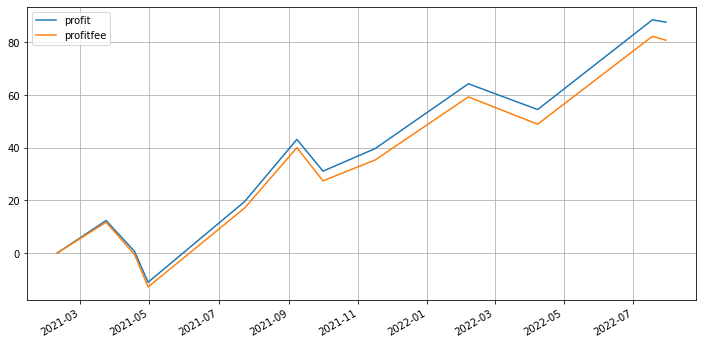

In [27]:
first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
buy = []
sell = []
sellshort = []
buytocover = []
timeList = [] 
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df)-1:
        break

    if df['close'][i] > df['ma'][i] + stdTimes*df['std'][i] and BS == None:
        temp = df['open'][i+1]
        tempSize = money / temp
        BS = 'B'
        t = i+1
        buy.append(t)
        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue
       
    if df['close'][i] < df['ma'][i] - stdTimes*df['std'][i] and BS == None:
        temp = df['open'][i+1]
        tempSize = money / temp
        BS = 'S'
        t = i+1
        sellshort.append(t)
        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue
        
    if (df['close'][i] <= df['ma'][i] or i == len(df)-2) and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp)
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
        
    if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
        profit = tempSize * (temp - df['open'][i+1])
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        buytocover.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

#### 未實現損益版

                              profit  profitfee
startTime                                      
2020-12-31 00:00:00+00:00   0.000000   0.000000
2021-01-01 00:00:00+00:00   0.000000   0.000000
2021-01-02 00:00:00+00:00   0.000000   0.000000
2021-01-03 00:00:00+00:00   0.000000   0.000000
2021-01-04 00:00:00+00:00   0.000000   0.000000
...                              ...        ...
2022-07-27 00:00:00+00:00  88.589276  82.323508
2022-07-28 00:00:00+00:00  88.589276  82.323508
2022-07-29 00:00:00+00:00  88.589276  82.323508
2022-07-30 00:00:00+00:00  88.283286  82.017518
2022-07-31 00:00:00+00:00  87.713223  80.850083

[578 rows x 2 columns]


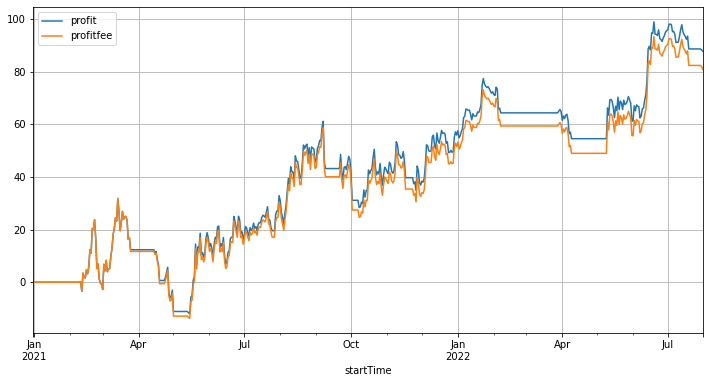

In [28]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df)-1:
        break

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if df['close'][i] > df['ma'][i] + stdTimes*df['std'][i]:
            tempSize = money / df['open'][i+1]
            BS = 'B'
            t = i+1
            buy.append(t)

        elif df['close'][i] < df['ma'][i] - stdTimes*df['std'][i]:
            tempSize = money / df['open'][i+1]
            BS = 'S'
            t = i+1
            sellshort.append(t)
        
    elif BS == 'B':
        profit = tempSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)
            
        if df['close'][i] <= df['ma'][i] or i == len(df)-2:
            pl_round = tempSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = tempSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)
        
        if df['close'][i] >= df['ma'][i] or i == len(df)-2:
            pl_round = tempSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

#### 含資金費率版
* 配合 FTX 一小時支付一次資金費率
* $fundingPayment = unit * price * fundingRate$
* if long, funding < 0 賺錢; else, 賠錢

In [29]:
rule = '1H'
df_hour = data.resample(rule=rule, closed='left', label='left').first()[['open']]

df_funding = pd.concat([df_hour, funding], axis=1)
df_funding = df_funding.fillna(method='bfill', limit=2).fillna(0)
df_funding

,open,rate
2020-12-31 16:00:00+00:00,28795.5,-0.000007
2020-12-31 17:00:00+00:00,28392.5,-0.000007
2020-12-31 18:00:00+00:00,28580.5,-0.000016
2020-12-31 19:00:00+00:00,28884.0,-0.000017
2020-12-31 20:00:00+00:00,28929.5,-0.000014
...,...,...
2022-07-31 13:00:00+00:00,23821.0,0.000003
2022-07-31 14:00:00+00:00,23719.0,-0.000001
2022-07-31 15:00:00+00:00,23731.0,0.000000
2022-07-31 16:00:00+00:00,23784.0,0.000001


In [30]:
def fundingPayment(df_funding, side, unit, t1, t2):
    
    if len(df_funding.loc[t1:t2]) == 0:
        fee = 0
    else:
        fr = np.array(df_funding.loc[t1:t2])
        fee = unit * np.dot(fr[:,0],fr[:,1])
        
    if side == 'long':
        return -fee
    elif side == 'short':
        return fee

                              profit  profitfee
startTime                                      
2020-12-31 00:00:00+00:00   0.000000   0.000000
2021-01-01 00:00:00+00:00   0.000000   0.000000
2021-01-02 00:00:00+00:00   0.000000   0.000000
2021-01-03 00:00:00+00:00   0.000000   0.000000
2021-01-04 00:00:00+00:00   0.000000   0.000000
...                              ...        ...
2022-07-27 00:00:00+00:00  88.589276  73.113547
2022-07-28 00:00:00+00:00  88.589276  73.113547
2022-07-29 00:00:00+00:00  88.589276  73.113547
2022-07-30 00:00:00+00:00  88.283286  72.807557
2022-07-31 00:00:00+00:00  87.713223  71.607838

[578 rows x 2 columns]


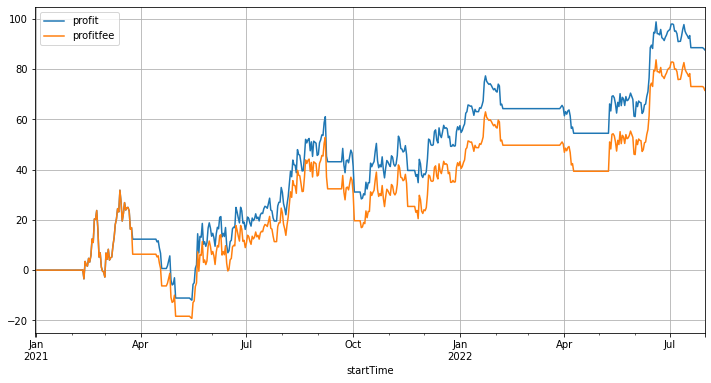

In [31]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df)-1:
        break

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if df['close'][i] > df['ma'][i] + stdTimes*df['std'][i]:
            tempSize = money / df['open'][i+1]
            BS = 'B'
            t = i+1
            buy.append(t)
            t1 = df.index[i+1]

        elif df['close'][i] < df['ma'][i] - stdTimes*df['std'][i]:
            tempSize = money / df['open'][i+1]
            BS = 'S'
            t = i+1
            sellshort.append(t)
            t1 = df.index[i+1]
        
    elif BS == 'B':
        profit = tempSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)
        t2 = df.index[i+1]
        fundingFee = fundingPayment(df_funding, 'long', tempSize, df.index[t], t2)
            
        if df['close'][i] <= df['ma'][i] or i == len(df)-2:
            pl_round = tempSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = df.index[i+1]
            
    elif BS == 'S': 
        profit = tempSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)
        t2 = df.index[i+1]
        fundingFee = fundingPayment(df_funding, 'short', tempSize, df.index[t], t2)
        
        if df['close'][i] >= df['ma'][i] or i == len(df)-2:
            pl_round = tempSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
               
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = df.index[i+1]
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

### Numpy Array

In [32]:
df.iloc[-2:]

,open,high,low,close,volume,ma,std
startTime,,,,,,,
2022-07-30 00:00:00+00:00,23784.0,24722.0,23522.0,23648.0,2.595692e+09,21260.350,1336.874935
2022-07-31 00:00:00+00:00,23648.0,23902.0,23533.0,23745.0,8.588459e+08,21336.475,1389.796535


In [33]:
time_arr = np.array(df.index)
df_arr = np.array(df)

                              profit  profitfee
startTime                                      
2020-12-31 00:00:00+00:00   0.000000   0.000000
2021-01-01 00:00:00+00:00   0.000000   0.000000
2021-01-02 00:00:00+00:00   0.000000   0.000000
2021-01-03 00:00:00+00:00   0.000000   0.000000
2021-01-04 00:00:00+00:00   0.000000   0.000000
...                              ...        ...
2022-07-27 00:00:00+00:00  88.589276  73.113547
2022-07-28 00:00:00+00:00  88.589276  73.113547
2022-07-29 00:00:00+00:00  88.589276  73.113547
2022-07-30 00:00:00+00:00  88.283286  72.807557
2022-07-31 00:00:00+00:00  87.713223  71.607838

[578 rows x 2 columns]


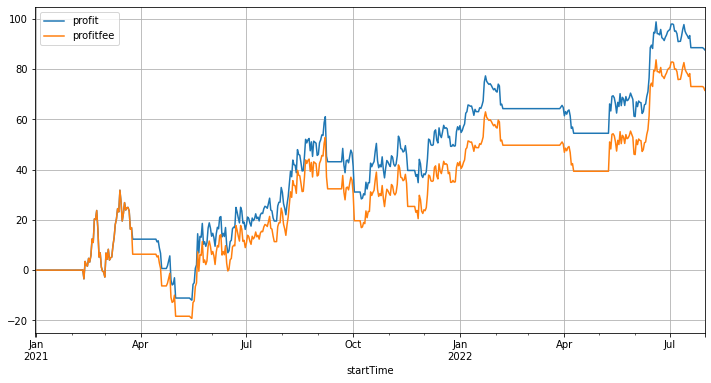

In [34]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if df_arr[i,3] > df_arr[i,5] + stdTimes*df_arr[i,6]:
            tempSize = money / df_arr[i+1,0]
            BS = 'B'
            t = i+1
            buy.append(t)
            t1 = time_arr[i+1]

        elif df_arr[i,3] < df_arr[i,5] - stdTimes*df_arr[i,6]:
            tempSize = money / df_arr[i+1,0]
            BS = 'S'
            t = i+1
            sellshort.append(t)
            t1 = time_arr[i+1]
        
    elif BS == 'B':
        profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)
            
        if df_arr[i,3] <= df_arr[i,5] or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]
            
    elif BS == 'S': 
        profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)
        
        if df_arr[i,3] >= df_arr[i,5] or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

#### 績效呈現

In [35]:
# 實際交易位置
print(buy)
print(sell)
print(sellshort)
print(buytocover)

[40, 104, 208, 280, 452, 575]
[84, 109, 252, 321, 464, 577]
[113, 133, 264, 327, 494]
[121, 206, 275, 403, 565]


In [36]:
equity.iloc[-3:]

,profit,profitfee
startTime,,
2022-07-29 00:00:00+00:00,88.589276,73.113547
2022-07-30 00:00:00+00:00,88.283286,72.807557
2022-07-31 00:00:00+00:00,87.713223,71.607838


In [37]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

In [38]:
equity.iloc[-3:]

,profit,profitfee,equity,drawdown_percent,drawdown
startTime,,,,,
2022-07-29 00:00:00+00:00,88.589276,73.113547,173.113547,-0.057818,-10.623266
2022-07-30 00:00:00+00:00,88.283286,72.807557,172.807557,-0.059483,-10.929256
2022-07-31 00:00:00+00:00,87.713223,71.607838,171.607838,-0.066013,-12.128976


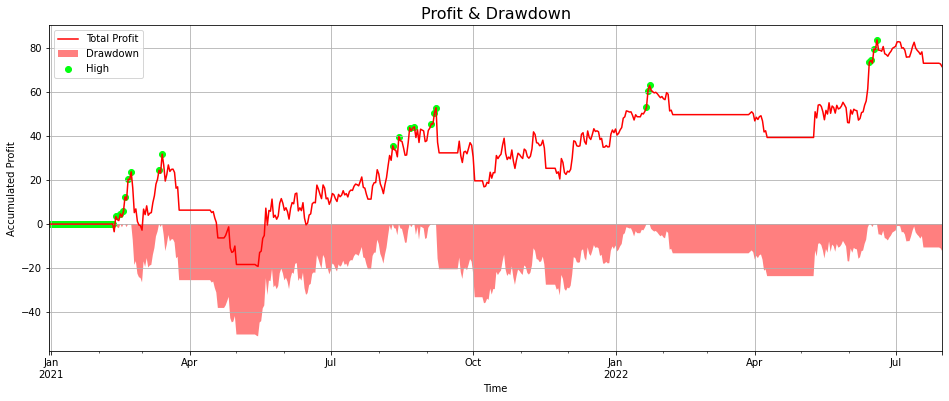

In [39]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

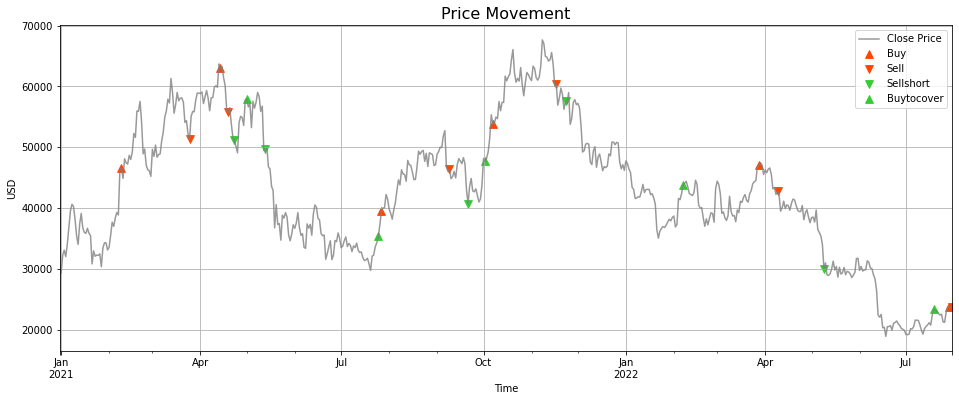

In [40]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[sellshort].index, df['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [41]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $71.61
return: 71.61%
mdd: 38.71%
calmarRatio: 1.85
tradeTimes: 11
winRate: 54.55%
profitFactor: 2.45
winLossRatio: 2.04


## 策略最佳化
* 針對「某一個」績效指標搜索樣本內的最佳解
* 對兩個參數找不含手續費的最佳解

In [42]:
data = pd.read_csv(path+'/BTC_PERP.csv', parse_dates=True, index_col='startTime')
funding = pd.read_csv(path+'/BTC_funding.csv', parse_dates=True, index_col='time')

In [43]:
df_inSample = data.loc[:'2022-2']
df_outOfSample = data.loc['2022-3':]

In [44]:
rule = '1H'
df_hour = data.resample(rule=rule, closed='left', label='left').first()[['open']]

df_funding = pd.concat([df_hour, funding], axis=1)
df_funding = df_funding.fillna(method='bfill', limit=2).fillna(0)
df_funding.iloc[-3:]

,open,rate
2022-07-31 15:00:00+00:00,23731.0,0.000000
2022-07-31 16:00:00+00:00,23784.0,0.000001
2022-07-31 17:00:00+00:00,23774.0,0.000000


### 樣本內

In [45]:
optimizationList = []

fund = 100
money = 100
feeRate = 0.003
# length = 40
# stdTimes = 2
rule = '1D'

for length in range(10,110,10):
    for stdTimes in np.arange(0.5, 3, 0.5):
        
        stdTimes = np.round(stdTimes,1)
        
        print('----------')
        print(f'length: {length}')
        print(f'stdTimes: {stdTimes}')

        d1 = df_inSample.resample(rule=rule, closed='left', label='left').first()[['open']]
        d2 = df_inSample.resample(rule=rule, closed='left', label='left').max()[['high']]
        d3 = df_inSample.resample(rule=rule, closed='left', label='left').min()[['low']]
        d4 = df_inSample.resample(rule=rule, closed='left', label='left').last()[['close']]
        d5 = df_inSample.resample(rule=rule, closed='left', label='left').sum()[['volume']]
        df = pd.concat([d1,d2,d3,d4,d5], axis=1)

        df['ma'] = df['close'].rolling(window=length, center=False).mean()
        df['std'] = df['close'].rolling(window=length, center=False).std()

        time_arr = np.array(df.index)
        df_arr = np.array(df)

        BS = None
        buy = []
        sell = []
        sellshort = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []

        for i in range(len(df_arr)):

            if i == len(df_arr)-1:
                break

            if BS == None:
                profit_list.append(0)
                profit_fee_list.append(0)

                if df_arr[i,3] > df_arr[i,5] + stdTimes*df_arr[i,6]:
                    tempSize = money / df_arr[i+1,0]
                    BS = 'B'
                    t = i+1
                    buy.append(t)
                    t1 = time_arr[i+1]

                elif df_arr[i,3] < df_arr[i,5] - stdTimes*df_arr[i,6]:
                    tempSize = money / df_arr[i+1,0]
                    BS = 'S'
                    t = i+1
                    sellshort.append(t)
                    t1 = time_arr[i+1]

            elif BS == 'B':
                profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
                profit_list.append(profit)
                t2 = time_arr[i+1]
                fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)

                if df_arr[i,3] <= df_arr[i,5] or i == len(df_arr)-2:
                    pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
                    profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    BS=None

                    # Realized PnL
                    profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    profit_fee_list_realized.append(profit_fee_realized)

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
                    t1 = time_arr[i+1]

            elif BS == 'S': 
                profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
                profit_list.append(profit)
                t2 = time_arr[i+1]
                fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)

                if df_arr[i,3] >= df_arr[i,5] or i == len(df_arr)-2:
                    pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
                    profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    profit_fee_list.append(profit_fee)
                    buytocover.append(i+1)
                    BS=None

                    # Realized PnL
                    profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    profit_fee_list_realized.append(profit_fee_realized)

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
                    t1 = time_arr[i+1]

        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd
        
        optimizationList.append([length, stdTimes, ret, calmarRatio])

----------
length: 10
stdTimes: 0.5
----------
length: 10
stdTimes: 1.0
----------
length: 10
stdTimes: 1.5
----------
length: 10
stdTimes: 2.0
----------
length: 10
stdTimes: 2.5
----------
length: 20
stdTimes: 0.5
----------
length: 20
stdTimes: 1.0
----------
length: 20
stdTimes: 1.5
----------
length: 20
stdTimes: 2.0
----------
length: 20
stdTimes: 2.5
----------
length: 30
stdTimes: 0.5
----------
length: 30
stdTimes: 1.0
----------
length: 30
stdTimes: 1.5
----------
length: 30
stdTimes: 2.0
----------
length: 30
stdTimes: 2.5
----------
length: 40
stdTimes: 0.5
----------
length: 40
stdTimes: 1.0
----------
length: 40
stdTimes: 1.5
----------
length: 40
stdTimes: 2.0
----------
length: 40
stdTimes: 2.5
----------
length: 50
stdTimes: 0.5
----------
length: 50
stdTimes: 1.0
----------
length: 50
stdTimes: 1.5
----------
length: 50
stdTimes: 2.0
----------
length: 50
stdTimes: 2.5
----------
length: 60
stdTimes: 0.5
----------
length: 60
stdTimes: 1.0
----------
length: 60
stdTim

In [46]:
optResult = pd.DataFrame(optimizationList, columns=['length','stdTimes','ret','calmarRatio'])
optResult

,length,stdTimes,ret,calmarRatio
0,10,0.5,-0.388009,-0.658636
1,10,1.0,-0.514682,-0.710429
2,10,1.5,-0.071982,-0.140514
3,10,2.0,0.290593,0.992982
4,10,2.5,-0.100621,-0.877455
5,20,0.5,-0.415505,-0.522643
6,20,1.0,-0.416371,-0.501222
7,20,1.5,-0.363650,-0.587313
8,20,2.0,-0.558528,-0.767172
9,20,2.5,-0.046279,-0.142153


In [47]:
optResult[(optResult['stdTimes'] == 2)].sort_values('ret', ascending=False).iloc[:5]

,length,stdTimes,ret,calmarRatio
18,40,2.0,0.497492,1.285051
3,10,2.0,0.290593,0.992982
28,60,2.0,0.246027,1.111857
23,50,2.0,0.232519,0.694874
33,70,2.0,0.060801,0.209110


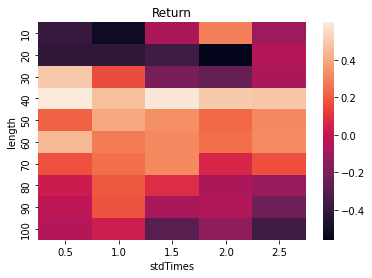

In [48]:
pic = optResult.pivot('length', 'stdTimes', 'ret')
sns.heatmap(data = pic).set(title='Return');

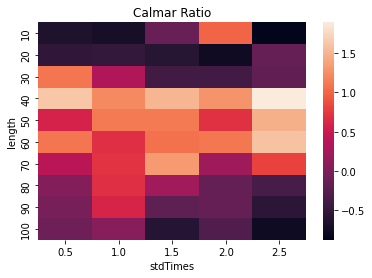

In [49]:
pic = optResult.pivot('length', 'stdTimes', 'calmarRatio')
sns.heatmap(data = pic).set(title='Calmar Ratio');

### 樣本外

In [62]:
fund = 100
money = 100
feeRate = 0.003
length = 30
stdTimes = 0.5
rule = '1D'

d1 = df_outOfSample.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = df_outOfSample.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = df_outOfSample.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = df_outOfSample.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = df_outOfSample.resample(rule=rule, closed='left', label='left').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)

df['ma'] = df['close'].rolling(window=length, center=False).mean()
df['std'] = df['close'].rolling(window=length, center=False).std()

time_arr = np.array(df.index)
df_arr = np.array(df)

In [63]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if df_arr[i,3] > df_arr[i,5] + stdTimes*df_arr[i,6]:
            tempSize = money / df_arr[i+1,0]
            BS = 'B'
            t = i+1
            buy.append(t)
            t1 = time_arr[i+1]

        elif df_arr[i,3] < df_arr[i,5] - stdTimes*df_arr[i,6]:
            tempSize = money / df_arr[i+1,0]
            BS = 'S'
            t = i+1
            sellshort.append(t)
            t1 = time_arr[i+1]
        
    elif BS == 'B':
        profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)
            
        if df_arr[i,3] <= df_arr[i,5] or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]
            
    elif BS == 'S': 
        profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        t2 = time_arr[i+1]
        fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)
        
        if df_arr[i,3] >= df_arr[i,5] or i == len(df_arr)-2:
            pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = time_arr[i+1]
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $32.85
return: 32.85%
mdd: 15.770000000000001%
calmarRatio: 2.08
tradeTimes: 6
winRate: 50.0%
profitFactor: 2.46
winLossRatio: 2.46


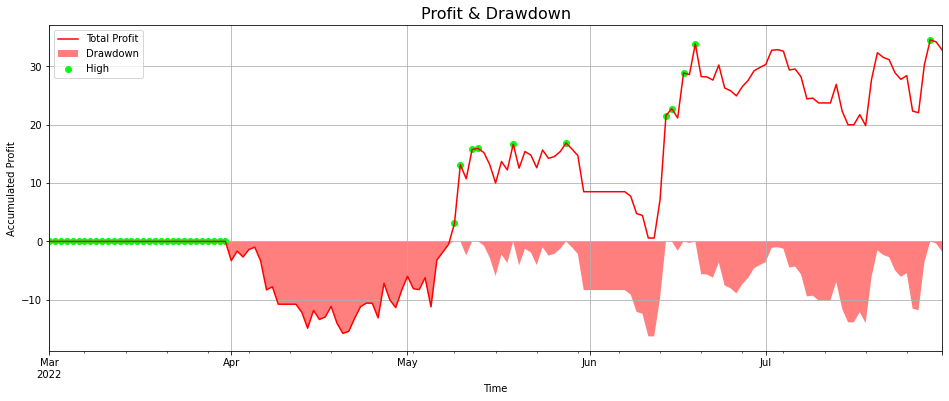

In [64]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

## 補充 - 價量指標撰寫
* [Talib 教學](https://medium.com/ai%E8%82%A1%E4%BB%94/%E7%94%A8-python-%E5%BF%AB%E9%80%9F%E8%A8%88%E7%AE%97-158-%E7%A8%AE%E6%8A%80%E8%A1%93%E6%8C%87%E6%A8%99-26f9579b8f3a)
* [Talib Doc](https://mrjbq7.github.io/ta-lib/)

In [53]:
import talib
from talib import abstract

In [54]:
data.tail()

,open,high,low,close,volume
startTime,,,,,
2022-07-31 17:55:00+00:00,23728.0,23732.0,23723.0,23729.0,265721.9599
2022-07-31 17:56:00+00:00,23729.0,23750.0,23729.0,23743.0,952606.3003
2022-07-31 17:57:00+00:00,23743.0,23749.0,23737.0,23747.0,303344.8408
2022-07-31 17:58:00+00:00,23747.0,23754.0,23730.0,23730.0,513780.1416
2022-07-31 17:59:00+00:00,23730.0,23749.0,23730.0,23745.0,402356.0500


In [55]:
data['close'].rolling(30).mean()

startTime
2020-12-31 16:00:00+00:00             NaN
2020-12-31 16:01:00+00:00             NaN
2020-12-31 16:02:00+00:00             NaN
2020-12-31 16:03:00+00:00             NaN
2020-12-31 16:04:00+00:00             NaN
                                 ...     
2022-07-31 17:55:00+00:00    23733.900000
2022-07-31 17:56:00+00:00    23734.600000
2022-07-31 17:57:00+00:00    23735.100000
2022-07-31 17:58:00+00:00    23734.766667
2022-07-31 17:59:00+00:00    23735.033333
Name: close, Length: 830881, dtype: float64

In [56]:
talib.ADX(df.high, df.low, df.close, timeperiod=14)

startTime
2022-03-01 00:00:00+00:00          NaN
2022-03-02 00:00:00+00:00          NaN
2022-03-03 00:00:00+00:00          NaN
2022-03-04 00:00:00+00:00          NaN
2022-03-05 00:00:00+00:00          NaN
                               ...    
2022-07-27 00:00:00+00:00    19.256065
2022-07-28 00:00:00+00:00    19.493292
2022-07-29 00:00:00+00:00    19.887031
2022-07-30 00:00:00+00:00    20.391529
2022-07-31 00:00:00+00:00    20.859991
Freq: D, Length: 153, dtype: float64

In [57]:
abstract.RSI(df, timeperiod=20)

startTime
2022-03-01 00:00:00+00:00          NaN
2022-03-02 00:00:00+00:00          NaN
2022-03-03 00:00:00+00:00          NaN
2022-03-04 00:00:00+00:00          NaN
2022-03-05 00:00:00+00:00          NaN
                               ...    
2022-07-27 00:00:00+00:00    52.349512
2022-07-28 00:00:00+00:00    55.697451
2022-07-29 00:00:00+00:00    55.361614
2022-07-30 00:00:00+00:00    54.714637
2022-07-31 00:00:00+00:00    55.108508
Freq: D, Length: 153, dtype: float64

## 補充 - 合併交割期貨
* 錄FTX交割期貨資料，並依下一份合約交易量大於原本合約時進行合併
* 提示：可作為外部資料使用 (永續交割期貨價差、近遠月交割期貨價差)
* 價差理論會收斂，使用上需要還原價格 (可能也需考慮資金費率等等因素)

In [52]:
symbolD1 = 'BTC-0624'
symbolD2 = 'BTC-0930'

deliveryList = [symbolD1, symbolD2]

In [57]:
startTime = '2022-6-1'
endTime = '2022-7-24'
resolution = 60
deliveryDf = pd.DataFrame()
s1 = time.time()

for symbol in deliveryList:
    startTimeStamp = dt.datetime.strptime(startTime, "%Y-%m-%d").timestamp()
    endTimeStamp = dt.datetime.strptime(endTime, "%Y-%m-%d").timestamp()
    delivery = []

    ## delivery
    while True:
        if startTimeStamp < endTimeStamp:
            t1 = startTimeStamp
            t2 = startTimeStamp + resolution*1000
            
            url = f'https://ftx.com/api/markets/{symbol}/candles?resolution={resolution}&limit=1440&start_time={t1}&end_time={t2}'
            response = requests.get(url)
            if response.status_code == 200:
                result = response.json()['result'][:-1] #最後一筆會重複
                delivery += result  
                startTimeStamp += resolution*1000
            else:
                print(f'error: {t1}~{t2}')
                startTimeStamp += resolution*1000
        else:
            break
            
    delivery = pd.DataFrame(delivery)
    delivery.index = pd.to_datetime(delivery['startTime'])
    delivery = delivery[['open', 'volume']]
    delivery.columns = [symbol.replace('-','_'), 'v_{}'.format(symbol.split('-')[1])]
    deliveryDf = pd.concat([deliveryDf, delivery], axis=1)

## 合併交割期貨
mix = []
numNow = 0
deliveryArr = np.array(deliveryDf)

for row in deliveryArr:
    
    mix.append(row[numNow*2])
 
    try: 
        if (np.isnan(row[numNow*2 + 2]) == False) & (row[numNow*2 + 3] > row[numNow*2 + 1]):
            numNow += 1
    except:
        numNow = numNow

delivery_ = pd.DataFrame(mix, index=deliveryDf.index)
delivery_.columns = ['{}_delivery'.format(symbolD1.split('-')[0])]    
    
s2 = time.time()
sMin = np.round((s2 - s1)/60, 2)
print('finish: {}, spend time: {} min'.format(deliveryList, sMin))

finish: ['BTC-0624', 'BTC-0930'], spend time: 1.15 min


In [58]:
delivery_

,BTC_delivery
startTime,
2022-05-31 16:00:00+00:00,32129.0
2022-05-31 16:01:00+00:00,32154.0
2022-05-31 16:02:00+00:00,32208.0
2022-05-31 16:03:00+00:00,32217.0
2022-05-31 16:04:00+00:00,32286.0
...,...
2022-07-23 13:47:00+00:00,22408.0
2022-07-23 13:48:00+00:00,22409.0
2022-07-23 13:49:00+00:00,22433.0
